<a href="https://colab.research.google.com/github/JanRusselCruz/SultiWag/blob/Source_Code/Sultiwag_Transcription.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [ ]:
# Mounting the google drive
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
# Importing the libraries
import os
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import glob
from tqdm import tqdm
from PIL import Image
import pandas as pd
import csv
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import tensorflow
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dropout
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from PIL import Image, ImageChops
import time

#Paths

In [ ]:
# Assigning the SpectogramCMK directory to variable path
path = "/content/gdrive/MyDrive/SultiWag/AudioFiles/02_Spectrograms/Consistent584_Spectrograms"
data_path = "/content/gdrive/MyDrive/SultiWag/AudioFiles/02_Spectrograms/"
newdata_path = "/content/gdrive/MyDrive/SultiWag/AudioFiles/05_Transcription/"
data_filename=""

#Functions and Models

In [ ]:
def create_numpy_from_spectrograms(path = ""):
    numpy_array = []    
    for filename in tqdm(sorted(glob.glob(os.path.join(path, '*.jpg')))):
        if "(R)" in filename:
            continue
        img = Image.open(filename)
        img = trim(img)
        h, w = img.size
        tmp_img = np.array(img)        
        np_img = []
        np_img = tmp_img[round(h/2)-1:h-1]
        file = filename.split("/")[-1].split(".")[0]  # get the file name without the path and extension
        term = file.split("_")  # split the file name into words
        english = term[0]  # the first word is the English word
        translation = term[1]  # the second word is the translation
        if len(term) < 3:
            translation_language = ""  # no suffix, set language code to empty string
        else:
            translation_language = term[2].split("(")[-1].split(")")[0]  # extract the language code from the third word
            translation = term[1].replace(term[2], "")  # remove the language code from the second word
            translation = f"{translation}({translation_language})"  # add the language code to the second word
        translation_language='cebuano'
        if('(M' in translation):
            translation_language='manobo'
        elif('(K' in translation):
            translation_language='kagan'
        # np_img_flipped = np.fliplr(np_img)  # flip the spectrogram horizontally
        numpy_array.append([english, translation, translation_language, np_img/255])
        # numpy_array.append([english, translation, translation_language, np_img_flipped/255])
    
    # numpy_array.sort(key=lambda x: x[2]) # sort by translation language
    # alternating_array = []
    # manobo_array = []
    # kagan_array = []
    # cebuano_array = []
    # for item in numpy_array:
    #     if item[2] == 'manobo':
    #         manobo_array.append(item)
    #     elif item[2] == 'kagan':
    #         kagan_array.append(item)
    #     else:
    #         cebuano_array.append(item)
    # max_len = max(len(manobo_array), len(kagan_array), len(cebuano_array))
    # for i in range(max_len):
    #     if i < len(manobo_array):
    #         alternating_array.append(manobo_array[i])
    #     if i < len(kagan_array):
    #         alternating_array.append(kagan_array[i])
    #     if i < len(cebuano_array):
    #         alternating_array.append(cebuano_array[i])
    
    # np.save("data.npy", alternating_array)
    # return alternating_array
    return numpy_array

In [ ]:
# Trimming the white spaces of a spectrogram
def trim(im):
    bg = Image.new(im.mode, im.size, im.getpixel((0,0)))
    diff = ImageChops.difference(im, bg)
    diff = ImageChops.add(diff, diff, 2.0, -100)
    bbox = diff.getbbox()
    if bbox:
        return im.crop(bbox)

In [ ]:
# Function to load the numpy array

def load_data(filename=""):
    spectrograms = []    
    
    data = np.load(newdata_path + "data_20230315-062845.npy", allow_pickle=True)
    flip = []

    # NOT NEEDED KAY NAANAI FLIPPED NA DATAS
    #for a in range(len(data)):
     # eng = data[a,0]
      #tran = data[a,1]
     # trans = data[0,2]
      #ima = np.flip(data[a,3])

      #flip.append([eng,tran,trans,ima])
      #np.save("data2.npy", flip)
    
    return data

#Define Models

In [ ]:
# Define Convolutional Neural Network model
def define_model():
    model = Sequential()    
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(51, 336, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv1D(24, 10, activation='relu', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv1D(12, 10, activation='relu', kernel_initializer='he_uniform'))
    model.add(Conv1D(5, 11, activation='relu', kernel_initializer='he_uniform'))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10810, activation='softmax'))
    
	# Compile model
    opt = SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
from keras.layers import BatchNormalization, Dropout
from keras.optimizers import Adam

def define_model2():
    model = Sequential()
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(51, 336, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.5))
    model.add(Dense(585, activation='softmax'))
    
    opt = SGD(learning_rate=0.05, momentum = 0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


In [ ]:
def define_model3():
    model = Sequential()    
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(51, 336, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))
    model.add(Conv1D(24, 10, activation='relu', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))
    model.add(Conv1D(12, 10, activation='relu', kernel_initializer='he_uniform'))
    model.add(Conv1D(5, 11, activation='relu', kernel_initializer='he_uniform'))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.2))
    model.add(Dense(585, activation='softmax'))
	# compile model
    opt = SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
def define_model1():
  model = Sequential()
  model.add(Conv2D(32, (3,3), activation='relu', input_shape=(51,336,3)))
  model.add(MaxPooling2D((2,2)))
  model.add(Conv2D(64, (3,3), activation='relu'))
  model.add(MaxPooling2D((2,2)))
  model.add(Conv2D(128, (3,3), activation='relu'))
  model.add(MaxPooling2D((2,2)))
  model.add(Conv2D(256, (3,3), activation='relu'))
  model.add(MaxPooling2D((2,2)))
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dropout(0.5))
  model.add(Dense(320, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dropout(0.5))
  model.add(Dense(585, activation='relu', kernel_initializer='he_uniform'))
  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  return model

In [ ]:
from keras.callbacks import EarlyStopping
from keras.layers import BatchNormalization, Dropout
from keras.optimizers import Adam

def define_model5():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(51, 336, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.7))
    model.add(Dense(30, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.7))
    model.add(Dense(585, activation='softmax'))
    
    opt = Adam(learning_rate=0.001)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    es = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')
    
    return model, es

In [ ]:
def define_model6():
  model = Sequential()
  model.add(Conv2D(32, (3,3), activation='relu', input_shape=(51,336,3)))
  model.add(MaxPooling2D((2,2)))
  model.add(Conv2D(64, (3,3), activation='relu'))
  model.add(MaxPooling2D((2,2)))
  model.add(Conv2D(128, (3,3), activation='relu'))
  model.add(MaxPooling2D((2,2)))
  model.add(Conv2D(128, (3,3), activation='relu'))
  model.add(MaxPooling2D((2,2)))
  model.add(Flatten())
  model.add(Dropout(0.5))
  model.add(Dense(512, activation='relu'))
  model.add(Dense(3, activation='softmax'))
  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  return model

In [ ]:
def define_model7():
  input_shape = (51,336,3)
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.2))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.2))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(Flatten())
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(32, activation='relu'))
  model.add(Dense(24, activation='softmax'))

#Running the functions

In [ ]:
data = create_numpy_from_spectrograms(path)

0it [00:00, ?it/s]


In [ ]:
#Saving the numpy array to the drive

timestr = time.strftime("%Y%m%d-%H%M%S")
data_filename="data_"+timestr+".npy"
np.save(newdata_path + 'data.npy',data)

In [ ]:
#Load the data

data = load_data()

#Loading the NPY files

In [ ]:
# Y_english = np.load(newdata_path+'Y_english.npy')
# X = np.load(newdata_path+'X.npy')
# Y_english_vec = np.load(newdata_path+'Y_english_vec.npy')
Xtrain = np.load(newdata_path + 'dataTrainX.npy')
Ytrain = np.load(newdata_path + 'dataTrainY.npy')
Xtest = np.load(newdata_path + 'dataTestX.npy')
Ytest = np.load(newdata_path + 'dataTestY.npy')
Xvalid = np.load(newdata_path + 'dataValidX.npy')
Yvalid = np.load(newdata_path + 'dataValidY.npy')

#Start Training

In [ ]:
model = define_model2()

In [ ]:
model.compile(optimizer='adam',
              loss=tensorflow.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

translationmodel2 = model.fit(Xtrain, Ytrain, epochs=2000, validation_data=(Xvalid,Yvalid), batch_size=64)

In [ ]:
model.save('Transcription_Model.h5')

In [ ]:
from tensorflow.keras.models import load_model

model2 = load_model('/content/gdrive/MyDrive/SultiWag/Models/Transcription_Model.h5')

In [ ]:
def load_recording_spectrograph(file=''):
    y, sr = librosa.load(file, sr=44100)
    f0, voiced_flag, voiced_probs = librosa.pyin(y, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
    times = librosa.times_like(f0)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    fig, ax = plt.subplots()
    img = librosa.display.specshow(D)  
    fig.savefig(file+".jpg")
    img2 = Image.open(file+".jpg")  
    return img2

In [ ]:
data_path = "/content/gdrive/MyDrive/SultiWag/AudioFiles/01_SlicedAudio/Cebuano/Cebuano_All_Letters"

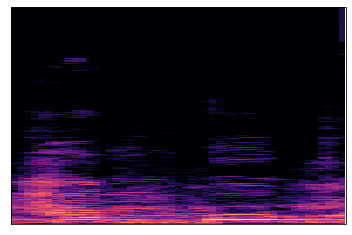

In [ ]:
chest = load_recording_spectrograph(data_path+"/haughty_hambog(C).mp3")

In [ ]:
def trim(im):
    bg = Image.new(im.mode, im.size, im.getpixel((0,0)))
    diff = ImageChops.difference(im, bg)
    diff = ImageChops.add(diff, diff, 2.0, -100)
    bbox = diff.getbbox()
    if bbox:
        return im.crop(bbox)

In [ ]:
img=trim(chest)
h, w = img.size
tmp_img = np.array(img)
np_img = []
np_img = tmp_img[round(h/2)-1:h-1]   

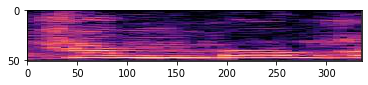

In [ ]:
plt.imshow(np_img)

In [ ]:
# shape when training/testing = [batch size, img_height, img_width, img_channels]
test_X1 = np_img
test_X1 = np.expand_dims(test_X1, axis=0)
print(test_X1.shape)
prediction  = model2.predict(test_X1)

(1, 51, 336, 3)
1/1 [==============================] - 0s 359ms/step


In [ ]:
classes_x=np.argmax(prediction,axis=1)
classes_x

In [ ]:
print(Ytest)

[[1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]]


In [ ]:
# Import necessary libraries
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load the trained model
model = define_model2()  # Define the model here

# Load the test data
test_y = np.argmax(Ytest, axis=1)

# Make predictions on the test data
y_pred = model.predict(Xtest)

classes_x = np.argmax(y_pred, axis=1)  # Use y_pred to calculate the class labels


# Evaluate the predictions
accuracy = accuracy_score(test_y, classes_x)
precision = precision_score(test_y, classes_x, average='weighted')
recall = recall_score(test_y, classes_x, average='weighted')
f1 = f1_score(test_y, classes_x, average='weighted')

print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("F1-Score: {:.2f}%".format(f1 * 100))

55/55 [==============================] - 1s 9ms/step
Accuracy: 0.29%
Precision: 0.03%
Recall: 0.29%
F1-Score: 0.04%


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
